357


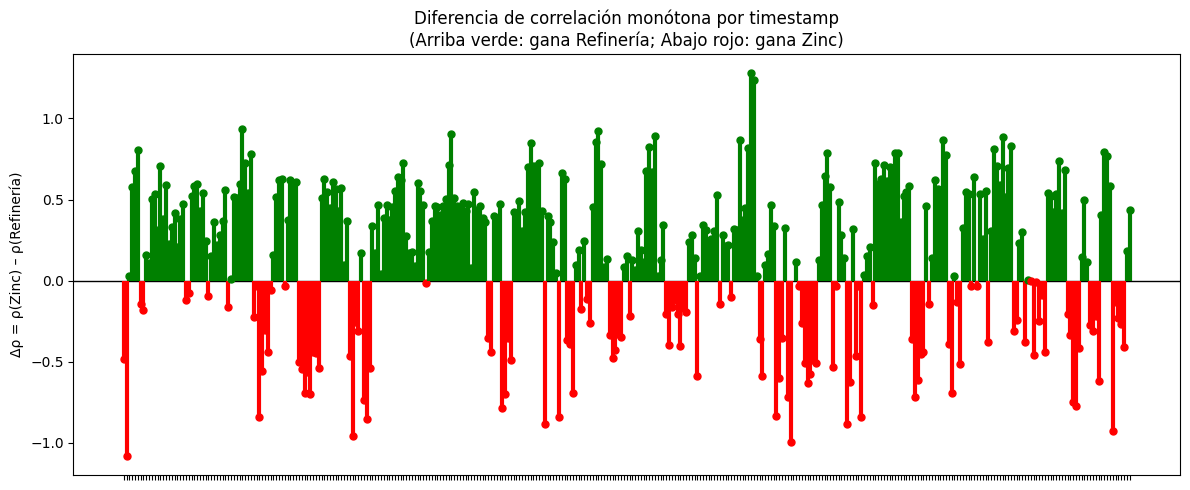

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ========= Config =========
INPUT = "tiempos_llegada_estimados.csv"    # o tu archivo original si ya tiene t_hr completos
FOCO_REF = "Refinería Cadereyta"
FOCO_ZIN = "Zinc Nacional"
MIN_N = 3   # mínimo de estaciones válidas (t_hr y so2_real) para calcular Spearman

# ========= Cargar CSV de forma robusta =========
df = pd.read_csv(INPUT, encoding="utf-8-sig", skipinitialspace=True)
df.columns = df.columns.str.strip()

# Normalizar nombres esperados
expected_cols = {"timestamp","foco","station","dist_m","t_hr","so2_real"}
missing = expected_cols - set(df.columns)
if missing:
    # intenta con lowercase si venían en minúsculas
    dfl = df.copy()
    dfl.columns = dfl.columns.str.lower()
    if expected_cols - set(dfl.columns):
        raise ValueError(f"Faltan columnas requeridas: {expected_cols - set(df.columns)}")
    else:
        df = dfl.rename(columns={c:c for c in dfl.columns})

# Tipos
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["t_hr"] = pd.to_numeric(df["t_hr"], errors="coerce")
df["so2_real"] = pd.to_numeric(df["so2_real"], errors="coerce")

# ========= Spearman por (timestamp, foco) =========
rows = []
for (ts, foco), g in df.groupby(["timestamp","foco"]):
    sub = g.dropna(subset=["t_hr","so2_real"])
    if len(sub) >= MIN_N:
        rho, p = spearmanr(sub["t_hr"], sub["so2_real"])
        rows.append({"timestamp": ts, "foco": foco, "rho": rho, "p_value": p, "n": len(sub)})
    else:
        rows.append({"timestamp": ts, "foco": foco, "rho": np.nan, "p_value": np.nan, "n": len(sub)})

corr = pd.DataFrame(rows)

# Pivote a formato ancho: columnas por foco con su rho
wide = corr.pivot(index="timestamp", columns="foco", values="rho").sort_index()

# Asegurarnos de que existen ambas columnas (pueden no estar en algunos ts)
for col in [FOCO_REF, FOCO_ZIN]:
    if col not in wide.columns:
        wide[col] = np.nan

# Δρ = ρ_Zinc – ρ_Refinería  (positivo => gana Refinería; negativo => gana Zinc)
wide["delta_rho"] = wide[FOCO_ZIN] - wide[FOCO_REF]

# También puedes guardar el resultado si quieres
wide.reset_index().to_csv("correlaciones_por_foco_y_delta.csv", index=False)

# ========= Gráfico “línea vertical” (barra arriba/abajo) por timestamp =========
x = np.arange(len(wide.index))
y = wide["delta_rho"].values

fig, ax = plt.subplots(figsize=(12, 5))

# Eje base en cero
ax.axhline(0, linewidth=1, color="black")

# Dibujar líneas verticales una por una con color por signo
for i, val in enumerate(y):
    if np.isnan(val):
        continue
    color = "green" if val > 0 else ("red" if val < 0 else "gray")
    ax.vlines(x=i, ymin=0, ymax=val, linewidth=3, color=color)
    ax.plot(i, val, "o", color=color, markersize=5)

print(len(x))

# Etiquetas y formato
ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_ylabel("Δρ = ρ(Zinc) – ρ(Refinería)")
ax.set_title("Diferencia de correlación monótona por timestamp\n(Arriba verde: gana Refinería; Abajo rojo: gana Zinc)")
plt.tight_layout()
plt.show()



In [23]:
import pandas as pd
import numpy as np

# Cargar correlaciones si ya las tienes guardadas
corr = pd.read_csv("correlaciones_por_foco_y_delta.csv")

# Si tu archivo tiene columnas: timestamp, "Refinería Cadereyta", "Zinc Nacional", "delta_rho"
# Filtramos las columnas relevantes
focos = ["Refinería Cadereyta", "Zinc Nacional"]

stats = []
for foco in focos:
    data = corr[foco].dropna()
    if len(data) == 0:
        continue
    stats.append({
        "Foco": foco,
        "n": len(data),
        "Media ρ": np.mean(data),
        "Mediana ρ": np.median(data),
        "Desviación estándar": np.std(data, ddof=1),
        "Mínimo ρ": np.min(data),
        "Máximo ρ": np.max(data),
        "Proporción ρ < 0": np.mean(data < 0),
        "Proporción |ρ| > 0.5": np.mean(abs(data) > 0.5),
    })

df_stats = pd.DataFrame(stats)
print(df_stats.to_string(index=False))

# También puedes agregar una métrica compuesta de “fuerza” de correlación:
df_stats["Magnitud media |ρ|"] = corr[focos].abs().mean()
print("\nMagnitud media de correlación (|ρ|):")
print(df_stats[["Foco", "Magnitud media |ρ|"]])


               Foco   n   Media ρ  Mediana ρ  Desviación estándar  Mínimo ρ  Máximo ρ  Proporción ρ < 0  Proporción |ρ| > 0.5
Refinería Cadereyta 356 -0.663043  -0.908555             0.416449 -1.000000  0.386147          0.898876              0.679775
      Zinc Nacional 357 -0.506760  -0.497046             0.213798 -0.985212  0.278257          0.994398              0.498599

Magnitud media de correlación (|ρ|):
                  Foco  Magnitud media |ρ|
0  Refinería Cadereyta                 NaN
1        Zinc Nacional                 NaN


In [22]:

# Si tu archivo tiene columnas: timestamp, "Refinería Cadereyta", "Zinc Nacional", "delta_rho"
# Filtramos las columnas relevantes
focos = ["Refinería Cadereyta", "Zinc Nacional"]

stats = []
for foco in focos:
    data = corr[foco].dropna()
    if len(data) == 0:
        continue
    stats.append({
        "Foco": foco,
        "n": len(data),
        "Media ρ": np.mean(data),
        "Mediana ρ": np.median(data),
        "Desviación estándar": np.std(data, ddof=1),
        "Mínimo ρ": np.min(data),
        "Máximo ρ": np.max(data),
        "Proporción ρ < 0": np.mean(data < 0),
        "Proporción |ρ| > 0.5": np.mean(abs(data) > 0.5),
    })

df_stats = pd.DataFrame(stats)
print(df_stats.to_string(index=False))

# También puedes agregar una métrica compuesta de “fuerza” de correlación:
df_stats["Magnitud media |ρ|"] = corr[focos].abs().mean()
print("\nMagnitud media de correlación (|ρ|):")
print(df_stats[["Foco", "Magnitud media |ρ|"]])


KeyError: 'Refinería Cadereyta'

C:\Users\Andre\AppData\Local\Temp\ipykernel_34516\1547325668.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(df["timestamp"].min(), df["timestamp"].max(), freq="H")


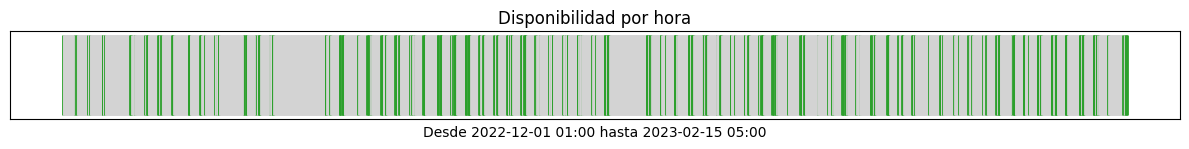

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- config ---------
INPUT = "tiempos_llegada_estimados.csv"  # o tu archivo actual

# --------- cargar ---------
df = pd.read_csv(INPUT, encoding="utf-8-sig", skipinitialspace=True)
df.columns = df.columns.str.strip().str.lower()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["t_hr"] = pd.to_numeric(df["t_hr"], errors="coerce")

# quitar filas sin timestamp
df = df.dropna(subset=["timestamp"]).sort_values("timestamp")

# --------- rango completo por hora ---------
full_range = pd.date_range(df["timestamp"].min(), df["timestamp"].max(), freq="H")

# --------- criterio: hay dato si ANY t_hr no es NaN en ese timestamp ---------
has_any = (
    df.groupby("timestamp")["t_hr"]
      .apply(lambda s: s.notna().any())
      .reindex(full_range, fill_value=False)
)

# --- Alternativa: requerir dato en AMBOS focos (descomenta este bloque si lo quieres) ---
# focos = ["Refinería Cadereyta", "Zinc Nacional"]
# g = df.pivot_table(index="timestamp", columns="foco", values="t_hr", aggfunc=lambda s: s.notna().any())
# has_any = g.reindex(full_range).fillna(False).apply(lambda r: all(r.get(f, False) for f in focos), axis=1)

# --------- plot tipo “barra unidimensional” con líneas verticales ---------
x = np.arange(len(full_range))
ymin, ymax = 0, 1

plt.figure(figsize=(12, 1.6))
for i, ok in enumerate(has_any.values):
    plt.vlines(i, ymin, ymax, linewidth=2, color=("tab:green" if ok else "lightgray"))

plt.yticks([])        # ocultar eje Y
plt.xticks([])        # ocultar etiquetas X para que no se amontonen
plt.title("Disponibilidad por hora")
# (Opcional) agrega texto con fechas de inicio/fin:
start_str = full_range[0].strftime("%Y-%m-%d %H:%M")
end_str   = full_range[-1].strftime("%Y-%m-%d %H:%M")
plt.xlabel(f"Desde {start_str} hasta {end_str}")

plt.tight_layout()
plt.show()


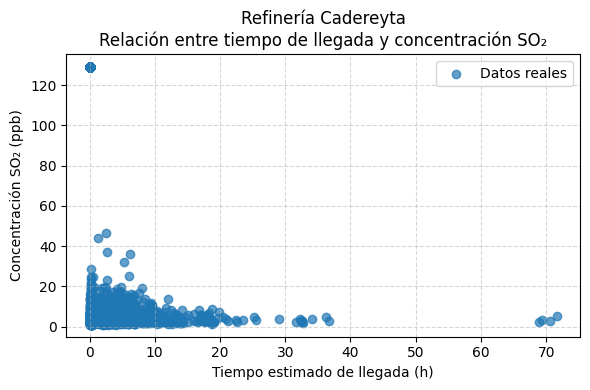

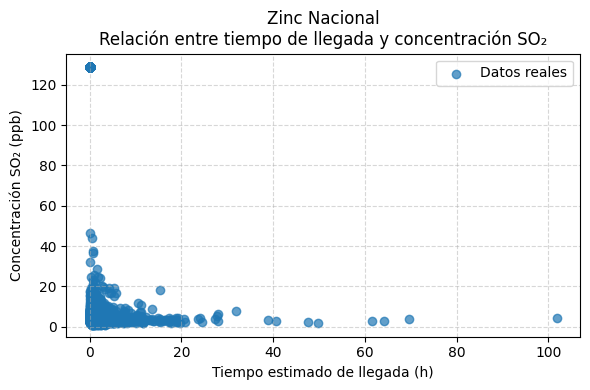

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- Config ----------
INPUT = "tiempos_llegada_estimados.csv"  # tu archivo
FOCOS = ["Refinería Cadereyta", "Zinc Nacional"]
MIN_N = 3  # mínimo de puntos válidos para graficar

# ---------- Cargar ----------
df = pd.read_csv(INPUT, encoding="utf-8-sig", skipinitialspace=True)
df.columns = df.columns.str.strip()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["t_hr"] = pd.to_numeric(df["t_hr"], errors="coerce")
df["so2_real"] = pd.to_numeric(df["so2_real"], errors="coerce")

# ---------- Función exponencial ----------
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# ---------- Graficar ----------
for foco in FOCOS:
    sub = df[df["foco"] == foco].copy()
    sub = sub.dropna(subset=["t_hr", "so2_real"])
    if len(sub) < MIN_N:
        print(f"⚠️ Pocos datos válidos para {foco} — {len(sub)} puntos")
        continue

    x = sub["t_hr"].values
    y = sub["so2_real"].values

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color="tab:blue", alpha=0.7, label="Datos reales")
    plt.title(f"{foco}\nRelación entre tiempo de llegada y concentración SO₂")
    plt.xlabel("Tiempo estimado de llegada (h)")
    plt.ylabel("Concentración SO₂ (ppb)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.ylim(-5, None)  # limitar eje Y desde -5

    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# ---------- Config ----------
INPUT = "tiempos_llegada_estimados.csv"
FOCOS = ["Refinería Cadereyta", "Zinc Nacional"]
MIN_N = 3  # mínimo de puntos válidos para calcular correlación

# ---------- Cargar ----------
df = pd.read_csv(INPUT, encoding="utf-8-sig", skipinitialspace=True)
df.columns = df.columns.str.strip()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["t_hr"] = pd.to_numeric(df["t_hr"], errors="coerce")
df["so2_real"] = pd.to_numeric(df["so2_real"], errors="coerce")

# ---------- Calcular correlaciones ----------
for foco in FOCOS:
    sub = df[df["foco"] == foco].copy()
    sub = sub.dropna(subset=["t_hr", "so2_real"])
    if len(sub) < MIN_N:
        print(f"⚠️ Pocos datos válidos para {foco} — {len(sub)} puntos")
        continue

    corr, pval = spearmanr(sub["t_hr"], sub["so2_real"])
    print(f"{foco}: correlación de Spearman = {corr:.4f}  (p = {pval:.4e})")


Refinería Cadereyta: correlación de Spearman = -0.1781  (p = 8.4995e-42)
Zinc Nacional: correlación de Spearman = -0.2622  (p = 2.0236e-90)


In [20]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# ======= Config =======
INPUT = "tiempos_llegada_estimados.csv"
FOCOS = ["Refinería Cadereyta", "Zinc Nacional"]
MIN_N = 3
ALPHAS = [0.05, 0.01]

# ======= Cargar =======
df = pd.read_csv(INPUT, encoding="utf-8-sig", skipinitialspace=True)
df.columns = df.columns.str.strip()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["t_hr"] = pd.to_numeric(df["t_hr"], errors="coerce")
df["so2_real"] = pd.to_numeric(df["so2_real"], errors="coerce")

# ======= Spearman por (timestamp, foco) =======
rows = []
for (ts, foco), g in df.groupby(["timestamp","foco"]):
    sub = g.dropna(subset=["t_hr","so2_real"])
    if len(sub) >= MIN_N:
        rho, p = spearmanr(sub["t_hr"], sub["so2_real"])
        rows.append({"timestamp": ts, "foco": foco, "rho": rho, "p_value": p, "n": len(sub)})
    else:
        rows.append({"timestamp": ts, "foco": foco, "rho": np.nan, "p_value": np.nan, "n": len(sub)})

corr = pd.DataFrame(rows)

# ======= Porcentaje de p-values significativos por foco =======
for foco in FOCOS:
    sub = corr[corr["foco"] == foco].copy()
    sub = sub.dropna(subset=["p_value"])  # sólo tests válidos
    total = len(sub)
    if total == 0:
        print(f"{foco}: sin tests válidos (n >= {MIN_N}).")
        continue

    print(f"\n=== {foco} ===")
    print(f"Tests válidos: {total}")
    for alpha in ALPHAS:
        sig = (sub["p_value"] < alpha).sum()
        pct = 100.0 * sig / total
        print(f"α = {alpha:.2f}: {sig}/{total} ({pct:.1f}%) con p < α (evidencia de correlación monótona)")

    # (Opcional) desagregar por signo de rho entre los significativos
    sig_mask = sub["p_value"] < ALPHAS[0]  # usa α=0.05 por defecto
    pos = (sub.loc[sig_mask, "rho"] > 0).sum()
    neg = (sub.loc[sig_mask, "rho"] < 0).sum()
    print(f"Entre los significativos (α=0.05): {pos} positivos, {neg} negativos")



=== Refinería Cadereyta ===
Tests válidos: 356
α = 0.05: 242/356 (68.0%) con p < α (evidencia de correlación monótona)
α = 0.01: 224/356 (62.9%) con p < α (evidencia de correlación monótona)
Entre los significativos (α=0.05): 0 positivos, 242 negativos

=== Zinc Nacional ===
Tests válidos: 357
α = 0.05: 178/357 (49.9%) con p < α (evidencia de correlación monótona)
α = 0.01: 99/357 (27.7%) con p < α (evidencia de correlación monótona)
Entre los significativos (α=0.05): 0 positivos, 178 negativos
